# Handwritten Doodle Recognition System
Quick Draw - A Google Doodle Recognition Clone

# Download the Dataset 

Loop over the classes and download the currospondent data

In [ ]:
!mkdir data

In [ ]:
import urllib.request
def download():
    base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
    for c in classes:        
        cls_url = c.replace('_', '%20')
        path = base+cls_url+'.npy'
        print(path)
        urllib.request.urlretrieve(path, 'data/'+c+'.npy')

In [ ]:
download()

# Imports 

In [1]:
import os
import glob
import numpy as np
import tensorflow
from tensorflow.python.keras import layers
from tensorflow import keras 
import tensorflow as tf

print(len(os.listdir('D:\Projects\QucikDraw-master\dataTwenty')))

20


# Load the Data 

Each class contains different number samples of arrays stored as .npy format.

In [2]:
l=os.listdir('D:\Projects\QucikDraw-master\dataTwenty')
classes=[x.split('.')[0] for x in l]
print("Total classes: ", len(classes))

Total classes:  20


In [3]:
print(classes)

['apple', 'banana', 'basket', 'book', 'bucket', 'butterfly', 'cake', 'candle', 'car', 'circle', 'eye', 'face', 'fan', 'fish', 'flower', 'grapes', 'hand', 'ladder', 'snake', 'square']


In [4]:
def load_data(root, vfold_ratio=0.2, max_items_per_class= 30000):
    all_files = glob.glob(os.path.join(root, '*.npy'))

    #initialize variables 
    x = np.empty([0, 784])
    y = np.empty([0])
    class_names = []

    #load each data file 
    for idx, file in enumerate(all_files):
        data = np.load(file)
        data = data[0: max_items_per_class, :]
        labels = np.full(data.shape[0], idx)

        x = np.concatenate((x, data), axis=0)
        y = np.append(y, labels)

        class_name, ext = os.path.splitext(os.path.basename(file))
        class_names.append(class_name)

    data = None
    labels = None
    
    #randomize the dataset 
    permutation = np.random.permutation(y.shape[0])
    x = x[permutation, :]
    y = y[permutation]

    #separate into training and testing 
    vfold_size = int(x.shape[0]/100*(vfold_ratio*100))

    x_test = x[0:vfold_size, :]
    y_test = y[0:vfold_size]

    x_train = x[vfold_size:x.shape[0], :]
    y_train = y[vfold_size:y.shape[0]]
    return x_train, y_train, x_test, y_test, class_names

In [5]:
x_train, y_train, x_test, y_test, class_names = load_data('D:\Projects\QucikDraw-master\dataTwenty')
num_classes = len(class_names)
image_size = 28

In [6]:
print(len(x_train))

480000


## Show some random data 

bucket


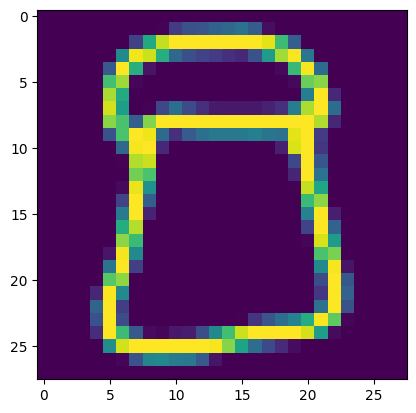

In [7]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline  
idx = randint(0, len(x_train))
plt.imshow(x_train[idx].reshape(28,28)) 
print(class_names[int(y_train[idx].item())])

# Preprocess the Data 

In [ ]:
# !pip install keras==2.6.0

In [7]:
from tensorflow.keras.utils import to_categorical

# Reshape and normalize
# convert from integers to floats
x_train = x_train.reshape(x_train.shape[0], image_size, image_size, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], image_size, image_size, 1).astype('float32')

# normalize to range 0-1
x_train /= 255.0
x_test /= 255.0

# Convert class vectors to class matrices
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# The Model 

In [8]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.layers import Dense,Flatten, Conv2D, BatchNormalization, MaxPooling2D, Dropout
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import pickle
from keras.callbacks import TensorBoard
import datetime

## Convoloutional Neural Network
- Loss function: Categorical Crossentropy
- Optimizer: Adam
- Batch Size: 256
- Epochs: 100 with EarlyStopping

Tip: Mention kernel_initializer to specify the distribution from which the weights are to be initialized
- model.add(Dense(10, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))

[Click here](https://datascience.stackexchange.com/questions/37378/what-are-kernel-initializers-and-what-is-their-significance)

In [13]:
os.getcwd()

'D:\\Projects\\Sketsy-main\\Tensorflow'

In [18]:
TensorBoard = "D:\Projects\Sketsy-main\Tensorflow\TensorBoard"
CNN_Logs = os.path.join(TensorBoard, "CNN_Logs")
MobileNet_Logs = os.path.join(TensorBoard, "MobileNet_Logs")
InceptionV3_Logs = os.path.join(TensorBoard, "InceptionV3_Logs")
VGG16_Logs = os.path.join(TensorBoard, "VGG16_Logs")
ResNet50_Logs = os.path.join(TensorBoard, "ResNet50_Logs")

In [21]:
# Define model
model = keras.Sequential()
model.add(Conv2D(16, (5, 5),padding='same',
                        input_shape=(28,28,1), activation='relu', kernel_initializer='he_normal'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax')) 

# Train model
model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])
# checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')
reduceLR = ReduceLROnPlateau(monitor='accuracy', factor=0.3, patience=3,
                      min_delta=0.005, mode='max', verbose=1)

earlyStop = EarlyStopping(monitor='val_loss', patience=5, mode="min", verbose=1)

# logdir = os.path.join(CNN_Logs, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
# tensorboard_callback = TensorBoard(logdir, histogram_freq=1)

callbacks_list = [reduceLR, earlyStop]

print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 28, 28, 16)        416       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 24, 24, 32)        12832     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 12, 12, 32)        128       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 2, 2, 64)          51264     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 1, 1, 64)         

# Training 

In [22]:
history_cnn = model.fit(x = x_train, y = y_train, validation_split=0.1, batch_size = 256, verbose=1, epochs=100, callbacks=callbacks_list)
history_cnn

Epoch 1/100
1688/1688 [==============================] - 34s 19ms/step - loss: 0.5438 - accuracy: 0.8522 - val_loss: 0.3320 - val_accuracy: 0.9105
Epoch 2/100
1688/1688 [==============================] - 31s 18ms/step - loss: 0.3343 - accuracy: 0.9123 - val_loss: 0.3081 - val_accuracy: 0.9174
Epoch 3/100
1688/1688 [==============================] - 30s 18ms/step - loss: 0.2964 - accuracy: 0.9222 - val_loss: 0.2773 - val_accuracy: 0.9255
Epoch 4/100
1688/1688 [==============================] - 30s 18ms/step - loss: 0.2753 - accuracy: 0.9271 - val_loss: 0.2641 - val_accuracy: 0.9300
Epoch 5/100
1688/1688 [==============================] - 31s 18ms/step - loss: 0.2607 - accuracy: 0.9306 - val_loss: 0.2532 - val_accuracy: 0.9316
Epoch 6/100
1688/1688 [==============================] - 30s 18ms/step - loss: 0.2480 - accuracy: 0.9342 - val_loss: 0.2604 - val_accuracy: 0.9305
Epoch 7/100
1688/1688 [==============================] - 31s 18ms/step - loss: 0.2382 - accuracy: 0.9366 - val_loss: 0

# Testing 

In [23]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuarcy: {:0.2f}%'.format(score[1] * 100))

Test accuarcy: 93.91%


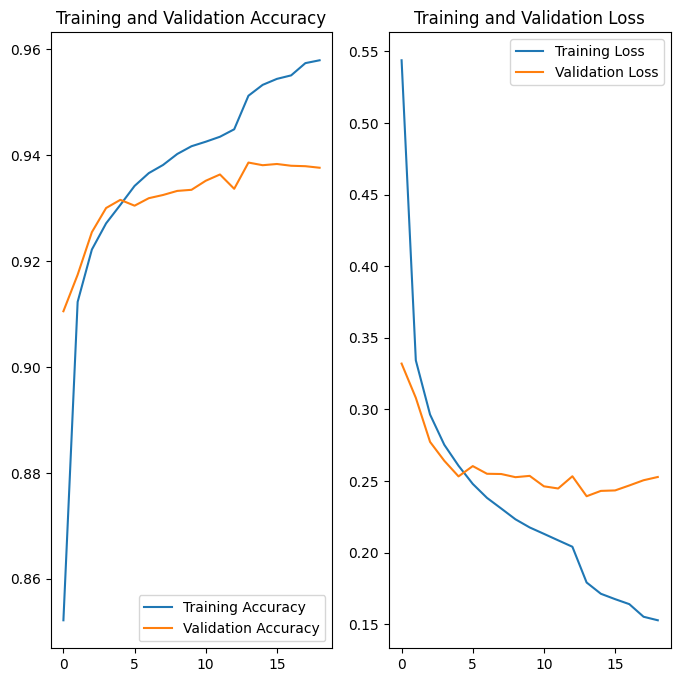

In [24]:
acc = history_cnn.history['accuracy']
val_acc = history_cnn.history['val_accuracy']

loss = history_cnn.history['loss']
val_loss = history_cnn.history['val_loss']

epochs_range = range(len(acc)) # the number of epochs completed 

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [36]:
conda install tf-nightly-gpu-2.0-preview


Note: you may need to restart the kernel to use updated packages.


In [37]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [39]:
%tensorboard --logdir {"D:\Projects\Sketsy-main\Tensorflow\TensorBoard\CNN_Logs\20221130-192836"}

Reusing TensorBoard on port 6006 (pid 4340), started 0:00:21 ago. (Use '!kill 4340' to kill it.)

# Inference 

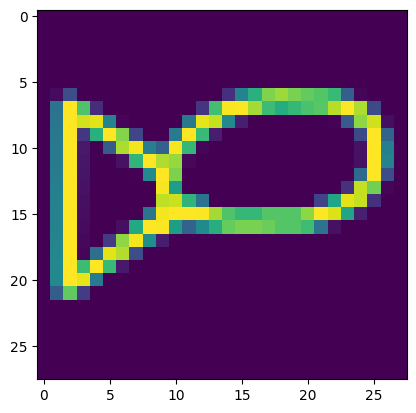

In [27]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline  
idx = randint(0, len(x_test))
img = x_test[idx]
plt.imshow(img.squeeze()) 

In [28]:
pred = model.predict(np.expand_dims(img, axis=0))[0]
ind = (-pred).argsort()[:2]
latex = [class_names[x] for x in ind]
print(latex)

['fish', 'circle']


In [29]:
#save the model
tf.keras.models.save_model(model,"cnn_20_30k_19ep_testacc-94.h5")

In [30]:
# load model
loaded_model = load_model('cnn_20_30k_19ep_testacc-94.h5')
print("Model loaded sucessfully")

Model loaded sucessfully


In [7]:
import os
os.getcwd()

'D:\\Projects\\Sketsy-main\\Tensorflow'

In [50]:
!mkdir model

In [31]:
# convert the h5 model to TensorFlow.js format
!tensorflowjs_converter --input_format keras cnn_20_30k_19ep_testacc-94.h5 CNN_JS_model/

In [14]:
# load the model and create predictions on the test set
loaded_model = load_model('D:\Projects\Sketsy-main\Tensorflow\Saved Models\cnn_20_20k_30ep.h5')
print("Model loaded sucessfully")

# predicted_classes = loaded_model.predict_classes(x_test)

predict_x = loaded_model.predict(x_test) 
predicted_classes = np.argmax(predict_x,axis=1)

# see which we predicted correctly and which not
correct_indices = np.nonzero(predicted_classes == y_test)[0]
incorrect_indices = np.nonzero(predicted_classes != y_test)[0]
print()
print(len(correct_indices)," classified correctly")
print(len(incorrect_indices)," classified incorrectly")

# adapt figure size to accomodate 18 subplots
plt.rcParams['figure.figsize'] = (7,14)

figure_evaluation = plt.figure()

# plot 9 correct predictions
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(6,3,i+1)
    plt.imshow(x_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title(
      "Predicted: {}, Truth: {}".format(predicted_classes[correct],
                                        y_test[correct]))
    plt.xticks([])
    plt.yticks([])

# plot 9 incorrect predictions
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(6,3,i+10)
    plt.imshow(x_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title(
      "Predicted {}, Truth: {}".format(predicted_classes[incorrect], 
                                       y_test[incorrect]))
    plt.xticks([])
    plt.yticks([])

figure_evaluation

Model loaded sucessfully


NameError: name 'x_test' is not defined

## CNN Architecture 2

In [10]:
from keras import layers

# Define model
model = keras.Sequential()
model.add(layers.Convolution2D(16, (3, 3),padding='same',input_shape=x_train.shape[1:], activation='relu'))
model.add(layers.Convolution2D(16, (3, 3),padding='same',input_shape=x_train.shape[1:], activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(layers.Convolution2D(32, (3, 3), padding='same', activation= 'relu'))
model.add(layers.Convolution2D(32, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(layers.Convolution2D(64, (3, 3), padding='same', activation= 'relu'))
model.add(layers.Convolution2D(64, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size =(2,2)))

model.add(layers.Dropout(0.1))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='tanh'))
model.add(layers.Dense(num_classes, activation='softmax'))

# Train model
model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])
# checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')
reduceLR = ReduceLROnPlateau(monitor='accuracy', factor=0.3, patience=3,
                      min_delta=0.005, mode='max', verbose=1)

earlyStop = EarlyStopping(monitor='val_loss', patience=5, mode="min", verbose=1)

# logdir = os.path.join(CNN_Logs, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
# tensorboard_callback = TensorBoard(logdir, histogram_freq=1)

callbacks_list = [reduceLR, earlyStop]

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 16)        2320      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 16)        64        
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 32)         

In [11]:
history_cnn2 = model.fit(x = x_train, y = y_train, validation_split=0.1, batch_size = 256, verbose=1, epochs=100, callbacks=callbacks_list)
history_cnn2

Epoch 1/100
1688/1688 [==============================] - 48s 24ms/step - loss: 0.3866 - accuracy: 0.8932 - val_loss: 0.2769 - val_accuracy: 0.9241
Epoch 2/100
1688/1688 [==============================] - 39s 23ms/step - loss: 0.2473 - accuracy: 0.9310 - val_loss: 0.2386 - val_accuracy: 0.9350
Epoch 3/100
1688/1688 [==============================] - 39s 23ms/step - loss: 0.2164 - accuracy: 0.9392 - val_loss: 0.2232 - val_accuracy: 0.9399
Epoch 4/100
1688/1688 [==============================] - 38s 23ms/step - loss: 0.1990 - accuracy: 0.9439 - val_loss: 0.2263 - val_accuracy: 0.9391
Epoch 5/100
1688/1688 [==============================] - 39s 23ms/step - loss: 0.1852 - accuracy: 0.9474 - val_loss: 0.2128 - val_accuracy: 0.9419
Epoch 6/100
1688/1688 [==============================] - 38s 23ms/step - loss: 0.1759 - accuracy: 0.9493 - val_loss: 0.2177 - val_accuracy: 0.9430
Epoch 7/100
1688/1688 [==============================] - 39s 23ms/step - loss: 0.1670 - accuracy: 0.9518 - val_loss: 0

In [12]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuarcy: {:0.2f}%'.format(score[1] * 100))

Test accuarcy: 94.74%


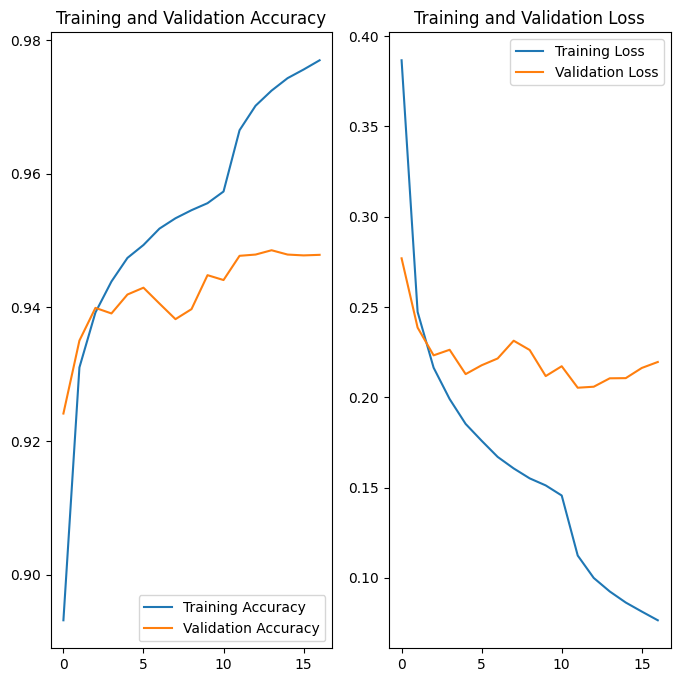

In [17]:
acc = history_cnn2.history['accuracy']
val_acc = history_cnn2.history['val_accuracy']

loss = history_cnn2.history['loss']
val_loss = history_cnn2.history['val_loss']

epochs_range = range(len(acc)) # the number of epochs completed 

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Improvement to Learning
There are many aspects of the learning algorithm that can be explored for improvement.

Perhaps the point of biggest leverage is the learning rate, such as evaluating the impact that smaller or larger values of the learning rate may have, as well as schedules that change the learning rate during training.

Another approach that can rapidly accelerate the learning of a model and can result in large performance improvements is batch normalization. We will evaluate the effect that batch normalization has on our baseline model.

Batch normalization can be used after convolutional and fully connected layers. It has the effect of changing the distribution of the output of the layer, specifically by standardizing the outputs. This has the effect of stabilizing and accelerating the learning process.

In [ ]:
model.add(BatchNormalization())

## Increase in Model Depth
There are many ways to change the model configuration in order to explore improvements over the baseline model.

Two common approaches involve changing the capacity of the feature extraction part of the model or changing the capacity or function of the classifier part of the model. Perhaps the point of biggest influence is a change to the feature extractor.

We can increase the depth of the feature extractor part of the model, following a VGG-like pattern of adding more convolutional and pooling layers with the same sized filter, while increasing the number of filters. In this case, we will add a double convolutional layer with 64 filters each, followed by another max pooling layer.

- A neural network has the property to memorize the characteristics of training data. This is called overfitting.

- In such a case, the network fails to generalize when subject to the test data.

- To avoid this tendency, the model uses a regularizing layer or function. A commonly used regularizing layer is referred to as a Dropout layer.

- Given a dropout rate (dropout=0.45), the Dropout layer randomly removes the fraction of units from participating in the next layer. For example, if the first layer has 256 units, after dropout=0.45 is applied, only (1 - 0.45) * 256 units = 140 units from layer 1 participate in layer 2.

- The Dropout layer makes neural networks robust to unforeseen input data because the network is trained to predict correctly, even if some units are missing.

- The dropout is not used in the output layer and it is only active during training. Moreover, dropout is not present during prediction.

- There are regularizers that can be used other than dropouts like l1 or l2. In Keras, the bias, weight and activation output can be regularized per layer. - l1 and l2 favor smaller parameter values by adding a penalty function. Both l1 and l2 enforce the penalty using a fraction of the sum of absolute (l1) or square (l2) of parameter values.

- So, the penalty function forces the optimizer to find parameter values that are small. Neural networks with small parameter values are more insensitive to the presence of noise from within the input data.

- So, the l2 weight regularizer with fraction=0.001 can be implemented as:

In [ ]:
from keras.regularizers import l2
model.add(Dense(hidden_units,
                kernel_regularizer=l2(0.001),
                input_dim=input_size))

- No additional layer is added if l1 or l2 regularization is used. The regularization is imposed in the Dense layer internally. For the proposed model, dropout still has a better performance than l2.